# VGG16_CNN
Pre-trained model

In [48]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten,Dropout, BatchNormalization, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow_addons.metrics import RSquare
from imgaug import augmenters as img_aug

import warnings
import random
import cv2
import pickle
import requests
import time

from pushover import Client

warnings.filterwarnings('ignore')

In [2]:
# Code to send notification to my phone

class PushoverCallback(tf.keras.callbacks.Callback):
    def __init__(self, client, title, sound, interval):
        super(PushoverCallback, self).__init__()
        self.client = client
        self.title = title
        self.sound = sound
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0:
            message = f"Epoch {epoch + 1}: val_loss={logs['val_loss']:.4f}"
            self.client.send_message(message, title=self.title, sound=self.sound)

class TimeoutMonitor(tf.keras.callbacks.Callback):
    def __init__(self, client, title, sound, timeout=300):
        super(TimeoutMonitor, self).__init__()
        self.client = client
        self.title = title
        self.sound = sound
        self.timeout = timeout
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        pass

    def on_epoch_begin(self, epoch, logs=None):
        if self.start_time is not None and (time.time() - self.start_time) > self.timeout:
            message = f"Training has not moved to the next epoch after {self.timeout} seconds"
            self.client.send_message(message, title=self.title, sound=self.sound)
            self.start_time = time.time()

pushover_api_token = 'a3vns7mdqta4mbp42eeqb1ymo6ear5'
pushover_user_key = 'u5c3e3f58nrkui6dpuk5njcpfigxie'
client = Client(pushover_user_key, api_token=pushover_api_token)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    #tf.config.experimental.set_virtual_device_configuration(
        #gpus[0],
        #[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) # Notice here
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


2023-03-30 21:54:38.596770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 21:54:39.538923: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6870 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-03-30 21:54:39.539704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9629 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5


In [4]:
# Load csv file 
df = pd.read_csv('../datasets/PiCar/training_norm.csv', index_col=False)
df.head()

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [5]:
df.shape

(13793, 3)

In [6]:
#df = df.drop('image_id', axis=1)
#df.head()

In [7]:
df['angle'].value_counts()

0.7500    2123
0.5000    2046
0.6875    2007
0.6250    1963
0.5625    1609
0.4375    1467
0.8125    1147
0.3750     428
0.8750     301
0.3125     213
0.2500     104
0.1250      99
0.1875      98
0.9375      65
0.0000      60
1.0000      35
0.0625      28
Name: angle, dtype: int64

In [8]:
a = df['image_id'].tolist()
b = [x for x in range(a[0], a[-1] + 1)]
missing_vals = list(set(a) ^ set(b))
print('Missing data:', missing_vals)

Missing data: [3141, 3999, 4895, 8285, 10171]


In [9]:
images_dir = '../datasets/PiCar/train/training_data'
file_list = os.listdir(images_dir)
image_paths = []
pattern = "*.png"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(images_dir,filename))

image_paths = natsorted(image_paths)
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/3141.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/3999.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/4895.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/8285.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/10171.png']

image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\3141.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\3999.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\4895.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\8285.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\10171.png']

images = pd.DataFrame (image_paths, columns = ['images'])
images.describe()

,images
count,13793
unique,13793
top,../datasets/PiCar/train/training_data/1.png
freq,1


In [10]:
df_all = pd.concat([df, images], axis=1)
df_all = df_all.drop('image_id', axis=1)
df_all.tail()

,angle,speed,images
13788,0.6250,1.0,../datasets/PiCar/train/training_data/13794.png
13789,0.4375,1.0,../datasets/PiCar/train/training_data/13795.png
13790,0.5625,0.0,../datasets/PiCar/train/training_data/13796.png
13791,0.6250,0.0,../datasets/PiCar/train/training_data/13797.png
13792,0.6875,1.0,../datasets/PiCar/train/training_data/13798.png


In [11]:
df_all.shape

(13793, 3)

In [12]:
#le = LabelEncoder()
#df_all['angle']= le.fit_transform(df_all['angle'])
#df_all.head()

image_path: ../datasets/PiCar/train/training_data/11.png
steering_Angle: 0.6875
Speed: 0.0


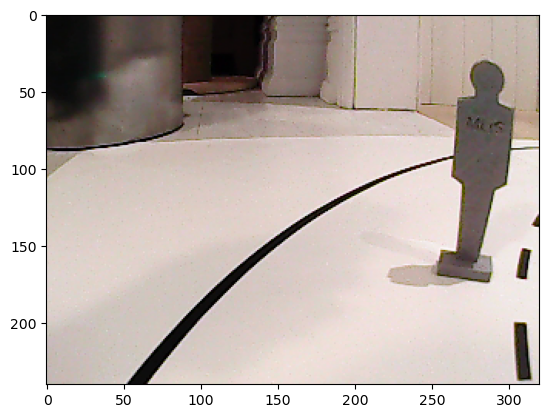

In [13]:
image_paths = df_all['images'].tolist()
steering_angles = df_all['angle'].tolist()
speed = df_all['speed'].tolist()


image_index = 10
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index]) 
print("steering_Angle:", steering_angles[image_index]) 
print("Speed:", speed[image_index]) 


(240, 320, 3)


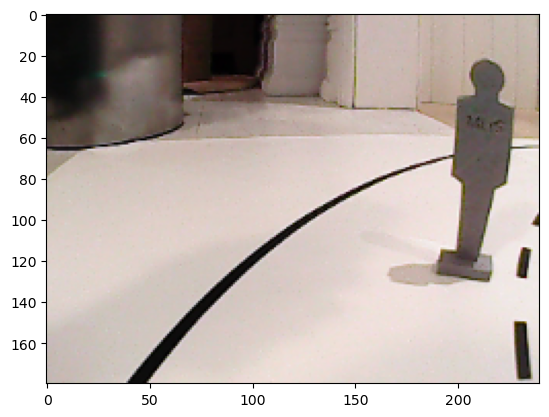

In [14]:
test_image = cv2.imread(df_all['images'][10])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
print(test_image.shape)
test_image = cv2.resize(test_image, (240,180))
plt.imshow(test_image)
plt.show()

In [15]:
X_train, X_valid = train_test_split( df_all, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 11034
Validation data: 2759


In [16]:
from tensorflow.keras.applications import VGG16

class VGG16_CNN(tf.keras.Model):
  def __init__(self):
    super().__init__()

    self.vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    self.conv1 = Conv2D(64, 3, activation='relu')# stride removing

    self.flatten = Flatten()
    self.d1 = Dense(100, activation='relu')
    self.d2 = Dense(50, activation='relu')
    self.d3 = Dense(10, activation='relu')
    self.d4 = Dense(5, activation='relu')

    self.Y1 = Dense(1, activation='relu')    
    self.Y2 = Dense(1, activation = 'sigmoid')

  def call(self, x):
    x = self.vgg(x)
    x = self.conv1(x)

    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    x = self.d4(x)

    y1 = self.Y1(x)
    y2 = self.Y2(x)
    
    return y1,y2

In [17]:
model = VGG16_CNN()
model.build((1,224, 224, 3))
model.summary()

Model: "vgg16_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             multiple                  294976    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  160100    
                                                                 
 dense_1 (Dense)             multiple                  5050      
                                                                 
 dense_2 (Dense)             multiple                  510       
                                                                 
 dense_3 (Dense)             multiple                  55

In [18]:
def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.2))  # zoom from 100% (no zoom) to 120%
    image = zoom.augment_image(image)
    return image

def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def blur(image):
    kernel_size = random.randint(1, 3)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
    return image

def random_augment(image):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    return image

In [19]:
def random_flip(image):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        image = cv2.flip(image,1)
    return image, is_flip

In [20]:
def custom_generator(df, batch_size, target_size, is_training):
    while True:
        # Shuffle the data
        df = df.sample(frac=1).reset_index(drop=True)
        for i in range(0, len(df), batch_size):
            batch = df[i:i+batch_size]
            # Load images and labels
            images = []
            angles = []
            speeds = []
            for _, row in batch.iterrows():
                img = cv2.imread(row['images'])
                angle = row['angle']
                speed = row['speed']

                if is_training:
                    img = random_augment(img)
                    img, is_flip = random_flip(img)
                    if is_flip:
                        angle = 1 - angle

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)

                images.append(img)
                angles.append(angle)
                speeds.append(speed)

            # Normalize images
            images = np.array(images) / 255.0
            # Convert labels to arrays
            angles = np.array(angles)
            speeds = np.array(speeds)
            yield images, {'output_1': angles, 'output_2': speeds}

In [22]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [23]:
tf.keras.backend.clear_session()

# Early stop added
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
pushover_callback = PushoverCallback(client=client, title='Model Training Update', sound='cashregister', interval=1)
timeout_callback = TimeoutMonitor(client=client, title='Training Stuck!!!!!!!!', sound='falling')

train_gen = custom_generator(X_train, batch_size=32 ,target_size=(224, 224), is_training= True)
val_gen = custom_generator(X_valid, batch_size=32, target_size=(224, 224), is_training= False)

model = VGG16_CNN()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                       loss={
        "output_1" : tf.keras.losses.MeanSquaredError(),
        "output_2" : tf.keras.losses.BinaryCrossentropy(from_logits=False)},
        metrics={"output_1": 'mse', "output_2": 'accuracy'})


history = model.fit(train_gen,
                    steps_per_epoch=len(X_train) // 32,
                    validation_data=val_gen,
                    validation_steps=len(X_valid) // 32,
                    callbacks=[callback, pushover_callback, timeout_callback],
                    epochs=150)

model.save('model/VGG16_CNN',save_format='tf')

history_path = os.path.join('history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

2023-03-30 21:55:36.100886: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-03-30 21:55:36.546923: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/150
344/344 [==============================] - 111s 306ms/step - loss: 0.2178 - output_1_loss: 0.0333 - output_2_loss: 0.1845 - output_1_mse: 0.0333 - output_2_accuracy: 0.9388 - val_loss: 0.1037 - val_output_1_loss: 0.0209 - val_output_2_loss: 0.0828 - val_output_1_mse: 0.0209 - val_output_2_accuracy: 0.9706
Epoch 2/150
344/344 [==============================] - 84s 230ms/step - loss: 0.1091 - output_1_loss: 0.0201 - output_2_loss: 0.0890 - output_1_mse: 0.0201 - output_2_accuracy: 0.9696 - val_loss: 0.0883 - val_output_1_loss: 0.0155 - val_output_2_loss: 0.0728 - val_output_1_mse: 0.0155 - val_output_2_accuracy: 0.9800
Epoch 3/150
344/344 [==============================] - 142s 413ms/step - loss: 0.0966 - output_1_loss: 0.0168 - output_2_loss: 0.0798 - output_1_mse: 0.0168 - output_2_accuracy: 0.9718 - val_loss: 0.0685 - val_output_1_loss: 0.0132 - val_output_2_loss: 0.0553 - val_output_1_mse: 0.0132 - val_output_2_accuracy: 0.9840
Epoch 4/150
344/344 [=======================

Epoch 27/150
344/344 [==============================] - 77s 225ms/step - loss: 0.0303 - output_1_loss: 0.0079 - output_2_loss: 0.0224 - output_1_mse: 0.0079 - output_2_accuracy: 0.9918 - val_loss: 0.0481 - val_output_1_loss: 0.0068 - val_output_2_loss: 0.0413 - val_output_1_mse: 0.0068 - val_output_2_accuracy: 0.9891
Epoch 28/150
344/344 [==============================] - 77s 225ms/step - loss: 0.0303 - output_1_loss: 0.0082 - output_2_loss: 0.0222 - output_1_mse: 0.0082 - output_2_accuracy: 0.9920 - val_loss: 0.0545 - val_output_1_loss: 0.0083 - val_output_2_loss: 0.0462 - val_output_1_mse: 0.0083 - val_output_2_accuracy: 0.9891
Epoch 29/150
344/344 [==============================] - 77s 225ms/step - loss: 0.0370 - output_1_loss: 0.0084 - output_2_loss: 0.0286 - output_1_mse: 0.0084 - output_2_accuracy: 0.9888 - val_loss: 0.0508 - val_output_1_loss: 0.0074 - val_output_2_loss: 0.0434 - val_output_1_mse: 0.0074 - val_output_2_accuracy: 0.9898
Epoch 30/150
344/344 [=====================

INFO:tensorflow:Assets written to: model/VGG16_CNN/assets


INFO:tensorflow:Assets written to: model/VGG16_CNN/assets


In [24]:
history_path = os.path.join('history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

def plots(history):
    # summarize history for accuracy
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(10,6))
    
    ax1.set_title('Angle Loss')
    ax1.plot(history['output_1_loss'])
    ax1.plot(history['val_output_1_mse'])
    ax1.set_yscale('log')
    ax1.legend(['train', 'test'], loc='lower right')
    
    ax2.set_title('Speed Accuracy')
    ax2.plot(history['output_2_accuracy'])
    ax2.plot(history['val_output_2_accuracy'])
    ax2.set_yscale('log')
    ax2.legend(['train', 'test'], loc='lower right')
    
    # summarize history for loss
    ax3.set_title('Angle MSE loss')  
    ax3.plot(history['output_1_loss'])
    ax3.plot(history['val_output_1_loss'])
    ax3.set_yscale('log')
    ax3.legend(['train', 'test'], loc='upper right')
   
    ax4.set_title('Speed loss')
    ax4.plot(history['output_2_loss'])
    ax4.plot(history['val_output_2_loss'])
    ax4.set_yscale('log')
    ax4.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

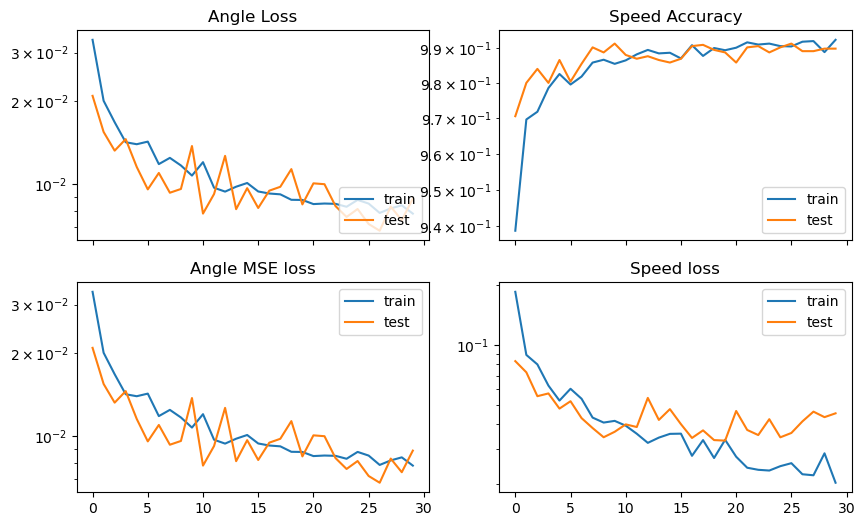

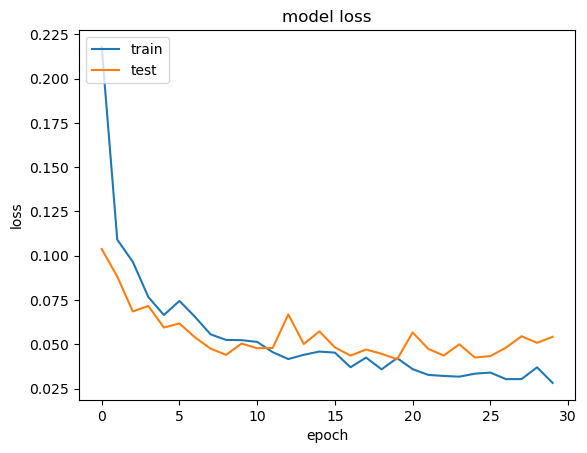

In [25]:
plots(history)

# Evaluation using validation set

In [50]:
def validation_generator(df, batch_size, target_size):
    while True:

        for i in range(0, len(df), batch_size):
            batch = df
            # Load images and labels
            images = []
            for _, row in batch.iterrows():
                img = cv2.imread(row['images'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                images.append(img)

            images = np.array(images) / 255.0

            yield images

In [51]:
from keras.models import load_model
model = load_model('model/VGG16_CNN')
valgen = next(validation_generator(X_valid, batch_size=2759, target_size=(224, 224)))
predict = model.predict(valgen)
print(predict)

2023-03-30 23:23:50.149361: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1661227008 exceeds 10% of free system memory.


87/87 [==============================] - 5s 58ms/step
(array([[0.6770985 ],
       [0.7286873 ],
       [0.47753942],
       ...,
       [0.45123875],
       [0.46571767],
       [0.49866068]], dtype=float32), array([[0.99993396],
       [0.99993527],
       [0.9999958 ],
       ...,
       [0.9999906 ],
       [0.99998045],
       [0.999673  ]], dtype=float32))


In [52]:
angles = pd.DataFrame(predict[0], columns=['angle'])
speed = pd.DataFrame(predict[1], columns=['speed'])
pred_df = pd.concat([angles, speed],axis=1)
pred_df.insert(0,"image_id", np.arange(1,len(pred_df)+1))

pred_df.head()

,image_id,angle,speed
0,1,0.677099,0.999934
1,2,0.728687,0.999935
2,3,0.477539,0.999996
3,4,0.279155,0.999580
4,5,0.451085,0.999985


In [53]:
pred_df.shape

(2759, 3)

### MSE before round

In [54]:
mse = tf.keras.losses.MeanSquaredError()
angle_mse = mse(X_valid['angle'], pred_df['angle']).numpy()
speed_mse = mse(X_valid['speed'], pred_df['speed']).numpy()
print(f'mse angle: {angle_mse}\nmse speed: {speed_mse}')

mse angle: 0.008854159153997898
mse speed: 0.008333549834787846


In [55]:
total_mse = angle_mse + speed_mse
print(f'Total mse: {total_mse}')

Total mse: 0.017187708988785744


In [56]:
pred_df_rnd = pred_df.round({'angle': 4,'speed': 0})
pred_df_rnd.head()

,image_id,angle,speed
0,1,0.6771,1.0
1,2,0.7287,1.0
2,3,0.4775,1.0
3,4,0.2792,1.0
4,5,0.4511,1.0


In [57]:
angle_mse = mse(X_valid['angle'], pred_df_rnd['angle']).numpy()
speed_mse = mse(X_valid['speed'], pred_df_rnd['speed']).numpy()
print(f'mse angle: {angle_mse}\nmse speed: {speed_mse}')

mse angle: 0.00885418988764286
mse speed: 0.009786154143512249


In [58]:
total_mse = angle_mse + speed_mse
print(f'Total mse: {total_mse}')

Total mse: 0.018640343099832535


In [59]:
pred_df_rnd['speed'] = pd.to_numeric(pred_df_rnd['speed'],downcast="integer" )
pred_df_rnd.head()

,image_id,angle,speed
0,1,0.6771,1
1,2,0.7287,1
2,3,0.4775,1
3,4,0.2792,1
4,5,0.4511,1


In [60]:
X_valid['speed']=X_valid['speed'].astype("int")
X_valid.head()

,angle,speed,images
13619,0.6875,1,../datasets/PiCar/train/training_data/13625.png
7027,0.9375,1,../datasets/PiCar/train/training_data/7031.png
10375,0.5625,1,../datasets/PiCar/train/training_data/10381.png
719,0.2500,1,../datasets/PiCar/train/training_data/720.png
7410,0.5000,1,../datasets/PiCar/train/training_data/7414.png


In [61]:
cm = confusion_matrix(X_valid['speed'], pred_df_rnd['speed'])

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       690
           1       0.99      1.00      0.99      2069

    accuracy                           0.99      2759
   macro avg       0.99      0.98      0.99      2759
weighted avg       0.99      0.99      0.99      2759



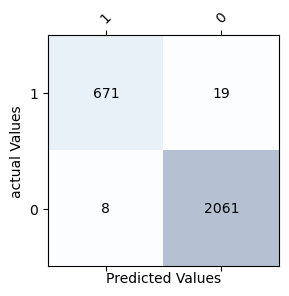

In [62]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
classes=["1", "0"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values',)
plt.ylabel('actual Values',);
print(classification_report(X_valid['speed'], pred_df_rnd['speed']))

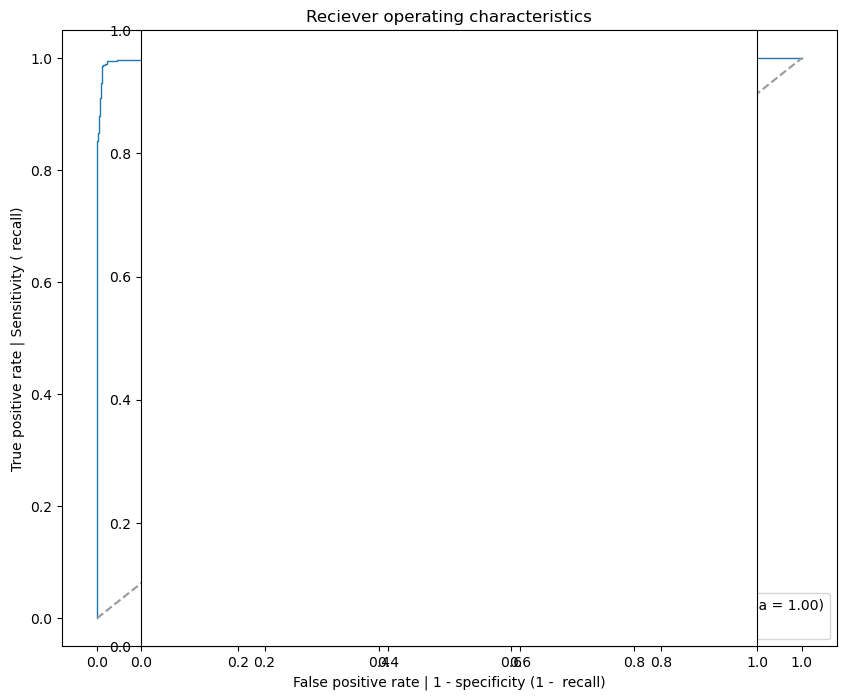

In [64]:
# Plot the rciever opertaing characteristic curve (ROC)
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10,8))
#probas_ = model.predict(X_valid['speed'])
fpr, tpr, thresholds = roc_curve(X_valid['speed'], pred_df['speed'])
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr, lw=1, label='ROC fold (area = %0.2f)' %(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate | 1 - specificity (1 -  recall)')
plt.ylabel('True positive rate | Sensitivity ( recall)')
plt.title('Reciever operating characteristics')
plt.legend(loc="lower right")
plt.axes().set_aspect(1);

# Testing

In [65]:
images_dir = '../datasets/PiCar/test'
file_list = os.listdir(images_dir)
image_paths = []
pattern = "*.png"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(images_dir,filename))

image_paths = natsorted(image_paths)

images = pd.DataFrame (image_paths, columns = ['images'])
images.describe()

,images
count,1020
unique,1020
top,../datasets/PiCar/test/1.png
freq,1


In [66]:
def test_generator(df, batch_size, target_size):
    while True:

        for i in range(0, len(df), batch_size):
            batch = df
            # Load images and labels
            images = []
            for _, row in batch.iterrows():
                img = cv2.imread(row['images'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                images.append(img)

            images = np.array(images) / 255.0

            yield images

In [67]:
from keras.models import load_model
model = load_model('model/VGG16_CNN')
testgen = next(test_generator(images, batch_size=1020, target_size=(224, 224)))
predict = model.predict(testgen)
print(predict)

32/32 [==============================] - 2s 59ms/step
(array([[0.4701935 ],
       [0.69952273],
       [0.16464736],
       ...,
       [0.35066307],
       [0.25652134],
       [0.08131767]], dtype=float32), array([[4.8308780e-06],
       [9.9996638e-01],
       [9.9909163e-01],
       ...,
       [9.9998760e-01],
       [9.9987006e-01],
       [9.9907815e-01]], dtype=float32))


In [68]:
angles = pd.DataFrame(predict[0], columns=['Angle'])
speed = pd.DataFrame(predict[1], columns=['speed'])
pred_df = pd.concat([angles, speed],axis=1)
pred_df.insert(0,"image_id", np.arange(1,len(pred_df)+1))

pred_df.head()

,image_id,Angle,speed
0,1,0.470194,0.000005
1,2,0.699523,0.999966
2,3,0.164647,0.999092
3,4,0.089324,0.998976
4,5,0.101690,0.999283


In [69]:
pred_df = pred_df.round({'Angle': 4})
pred_df.head()

,image_id,Angle,speed
0,1,0.4702,0.000005
1,2,0.6995,0.999966
2,3,0.1646,0.999092
3,4,0.0893,0.998976
4,5,0.1017,0.999283


In [70]:
pred_df.to_csv('Tow_mat_VGG16.csv', index=False)

In [35]:
test = next(custom_generator(X_valid, batch_size=10, target_size=(240, 120), is_training=False))

In [36]:
predict_test = model.predict(test[0])

1/1 [==============================] - 0s 18ms/step


In [37]:
print(predict_test[0])

[[0.5511235 ]
 [0.7568309 ]
 [0.7777829 ]
 [0.72114545]
 [0.4993554 ]
 [0.54714364]
 [0.47722927]
 [0.5665439 ]
 [0.6199493 ]
 [0.7158552 ]]


In [38]:
print(test[1])

{'output_1': array([0.625 , 0.75  , 0.6875, 0.6875, 0.5   , 0.5   , 0.5   , 0.5625,
       0.625 , 0.6875]), 'output_2': array([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.])}
